# Projet de reconnaissance faciale

# Reconnaissance faciale avec TensorFlow

## Preparation des données

In [24]:
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Dataset parameters
dataset_path = "dataset"
batch_size = 32
img_height = 224
img_width = 224

# Get all subdirectories in the dataset folder
class_names = tf.io.gfile.listdir(str(dataset_path))

# Prepare training and validation datasets
train_images = []
train_labels = []
val_images = []
val_labels = []

for label, class_name in enumerate(class_names):
    # Get image paths for this class
    image_paths = glob.glob(f"{dataset_path}/{class_name}/*.jpg")

    for i, image_path in enumerate(image_paths):
        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(
            image_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        # Split into train and validation
        if i < 3:
            train_images.append(img_array)
            train_labels.append(label)
        else:
            val_images.append(img_array)
            val_labels.append(label)

# Convert to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Convert labels to one-hot encoding
num_classes = len(class_names)
train_labels_onehot = np.eye(num_classes)[train_labels]
val_labels_onehot = np.eye(num_classes)[val_labels]

# Print class names
print("Classes:", class_names)

Classes: ['Angelina Jolie', 'Ben Afflek', 'Brad Pitt', 'Chris Martin', 'Denzel Washington', 'Elton John', 'Hugh Jackman', 'Jennifer Lawrence', 'Jerry Seinfeld', 'Johnny Depp', 'Kate Winslet', 'Killian Mbappé', 'Leonardo DiCaprio', 'Mathis Wauters', 'Megan Fox', 'Mindy Kaling', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


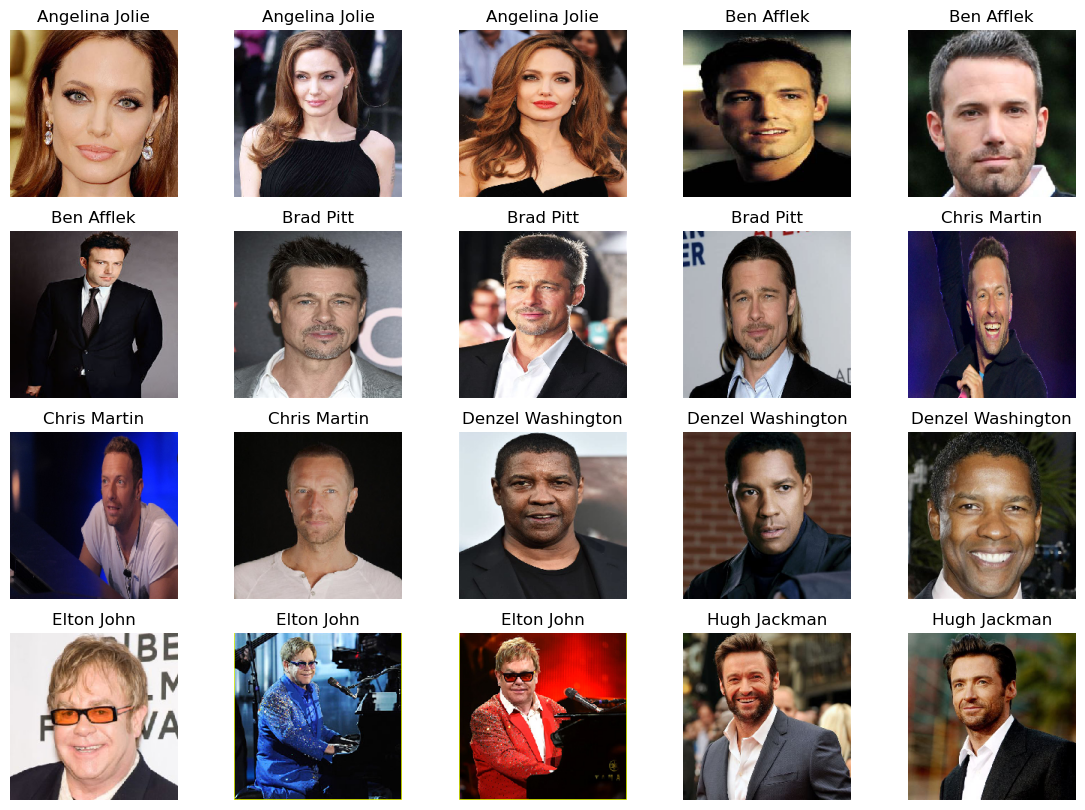

In [25]:
# Plot first 20 training images
plt.figure(figsize=(14, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis("off")
plt.show()

## Définir le modèle

In [26]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Charger MobileNetV2 sans la dernière couche
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Geler les couches du modèle pré-entraîné
base_model.trainable = False

# Ajouter des couches personnalisées
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes))

# Compiler le modèle
model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Résumé du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │        30,744 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,288,728 (8.73 MB)

 Trainable params: 30,744 (120.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Data augmentation et entraînement du modèle

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Préparer les générateurs de données
train_generator = train_datagen.flow(train_images, train_labels_onehot, batch_size=batch_size)
val_generator = train_datagen.flow(val_images, val_labels_onehot, batch_size=batch_size)


# Entraîner le modèle
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.0217 - loss: 0.8409 - val_accuracy: 0.0426 - val_loss: 0.3943
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0473 - loss: 0.3654 - val_accuracy: 0.0426 - val_loss: 0.2315
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0208 - loss: 0.2261 - val_accuracy: 0.0426 - val_loss: 0.1949
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0349 - loss: 0.1929 - val_accuracy: 0.0426 - val_loss: 0.1984
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.0674 - loss: 0.1929 - val_accuracy: 0.0426 - val_loss: 0.2059
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 966ms/step - accuracy: 0.1049 - loss: 0.1921 - val_accuracy: 0.0638 - val_loss: 0.2084
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 995ms/step - accuracy: 0.1033 - loss: 0.1918 - val_accuracy: 0.0851 - val_loss: 0.2134
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 989ms/step - accuracy: 0.1880 - loss: 0.1933 - val_accuracy: 0.0851 - val_loss: 0.2092
Epoch 9

## Visualisation des résultats

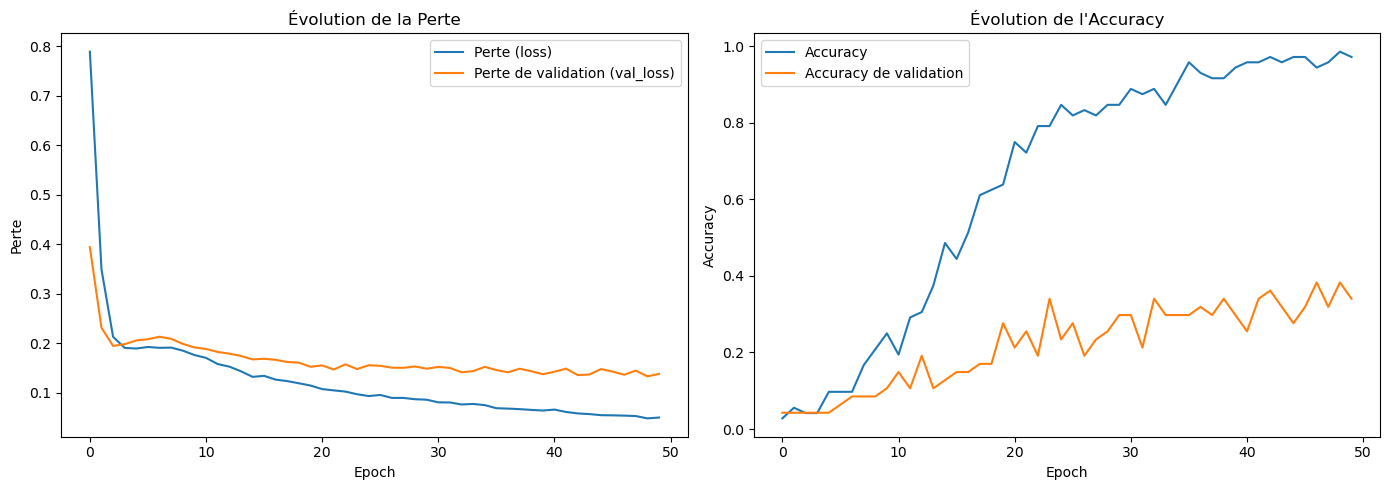

Final training accuracy: 0.9722


In [28]:
# Visualisation des résultats
import matplotlib.pyplot as plt

# Afficher la perte et l'accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte (loss)')
plt.plot(history.history['val_loss'], label='Perte de validation (val_loss)')
plt.title('Évolution de la Perte')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

# Afficher l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Accuracy de validation')
plt.title('Évolution de l\'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print the final accuracy
final_accuracy = history.history['accuracy'][-1]
print(f"Final training accuracy: {final_accuracy*100:.2f}%")

## Sauvegarde du modèle

In [29]:
model.save("face_recognition_model.keras")

## Reconnaissance faciale en temps réel

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import cv2
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
from tkinter import Tk, Label
from tkinter import simpledialog
from scipy.special import expit
import csv
from datetime import datetime
import threading
import tkinter as tk
from tkinter import messagebox

# Charger le modèle sauvegardé
model = tf.keras.models.load_model("face_recognition_model.keras")
class_names = tf.io.gfile.listdir(str('dataset'))

# Initialiser le classificateur de visage d'OpenCV
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Dimensions des images attendues
img_height = 224
img_width = 224

def capture_face(prenom, nom):
    # Créer le dossier pour enregistrer les images si il n'existe pas
    folder_name = f"dataset/{prenom.capitalize()} {nom.capitalize()}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Ouvrir la caméra
    cap = cv2.VideoCapture(0)
    captured_images = 0
    directions = ["Regardez en face", "Regardez en haut", "Regardez vers la droite", "Regardez en bas", "Regardez vers la gauche"]
    images_per_direction = 1  # Nombre d'images par direction
    total_images = len(directions) * images_per_direction

    direction_index = 0

    while captured_images < total_images:
        # Récupérer l'étape actuelle sans print
        current_direction = directions[direction_index]

        # Pause de 3 secondes avec affichage de l'étape actuelle
        for i in range(3, 0, -1):
            ret, frame = cap.read()
            if not ret:
                break
            # Ajouter le texte pour guider l'utilisateur
            cv2.putText(frame, f"{current_direction} dans {i} secondes",
                        (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
            cv2.imshow('Capturer le visage', frame)
            cv2.waitKey(1000)

        while captured_images < (direction_index + 1) * images_per_direction:
            ret, frame = cap.read()
            if not ret:
                break

            # Convertir en niveaux de gris pour la détection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Détection des visages
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            for (x, y, w, h) in faces:
                # Élargir la zone pour prendre toute la tête
                x_head = max(0, x - int(0.2 * w))  # 20% de plus sur les côtés
                y_head = max(0, y - int(0.3 * h))  # 30% de plus en haut pour inclure plus de tête
                w_head = min(frame.shape[1] - x_head, int(w * 1.4))  # Largeur augmentée
                h_head = min(frame.shape[0] - y_head, int(h * 1.6))  # Hauteur augmentée

                # Extraire toute la tête
                head = frame[y_head:y_head+h_head, x_head:x_head+w_head]

                # Enregistrer l'image
                head_filename = f"{folder_name}/head_{captured_images}.jpg"
                cv2.imwrite(head_filename, head)
                captured_images += 1

                # Ajouter un rectangle et des informations à l'écran
                cv2.putText(frame, f"Image {captured_images}/{total_images}",
                            (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.rectangle(frame, (x_head, y_head), (x_head+w_head, y_head+h_head), (0, 255, 0), 2)

            # Afficher l'étape actuelle pendant la capture
            cv2.putText(frame, f"Etape actuelle : {current_direction}",
                        (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

            # Afficher le flux vidéo avec les visages détectés
            cv2.imshow('Capturer le visage', frame)

            # Quitter avec la touche 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                return

        # Passer à la prochaine direction
        direction_index = (direction_index + 1) % len(directions)

    # Libérer les ressources
    cap.release()
    cv2.destroyAllWindows()
    show_message(f"Enregistrement terminé. Les visages ont été enregistrés dans le dossier : {folder_name}")

# Fonction pour effectuer une prédiction
def predict_face(face, model, class_names, threshold=0.6):
    """
    Prédit la classe d'un visage et vérifie s'il est inconnu.
    Args:
        face: Image du visage.
        model: Modèle de reconnaissance faciale.
        class_names: Liste des noms de classes.
        threshold: Seuil de confiance pour les visages inconnus.

    Returns:
        predicted_class: Nom de la classe prédite ou 'Inconnu'.
        confidence: Confiance de la prédiction.
    """
    face = cv2.resize(face, (img_width, img_height))  # Redimensionner
    face_array = img_to_array(face) / 255.0  # Normaliser
    face_array = np.expand_dims(face_array, axis=0)  # Ajouter une dimension batch

    # Obtenir les prédictions (logits)
    probabilities = model.predict(face_array, verbose=0)[0]  # Sortie du modèle
    softmax_p = np.exp(probabilities) / np.sum(np.exp(probabilities), axis=-1)  # Probabilités softmax

    # Obtenir la classe avec la probabilité maximale
    max_index = np.argmax(softmax_p)
    confidence = expit(probabilities[max_index])

    # Vérifier si le visage est inconnu
    if confidence < threshold:
        return "Inconnu", confidence
    else:
        predicted_class = class_names[max_index]
        return predicted_class, confidence

def show_message(message, duration=5):
    """
    Affiche un message dans une fenêtre pendant une durée spécifiée.
    """
    root = Tk()
    root.title("Prochaine étape")
    root.geometry("300x100")
    label = Label(root, text=message, font=("Helvetica", 16), wraplength=280)
    label.pack(expand=True)
    root.after(duration * 1000, root.destroy)  # Ferme la fenêtre après `duration` secondes
    root.mainloop()

def detect_cameras():
    """
    Détecte les caméras disponibles
    """
    available_cameras = []
    for i in range(10):  # Testons les 10 premiers indices
        cap = cv2.VideoCapture(i)
        if cap.isOpened():
            # Récupérer des informations sur la caméra
            backend_name = cap.getBackendName()
            available_cameras.append({
                'index': i,
                'backend': backend_name
            })
            cap.release()
    return available_cameras

def start_multi_camera_recognition():
    """
    Démarrer la reconnaissance faciale sur deux caméras
    """
    cameras = detect_cameras()

    if len(cameras) < 2:
        messagebox.showerror("Erreur", "Pas assez de caméras détectées!")
        return

    # Paramètres des caméras
    camera_params = [
        {'index': cameras[0]['index'], 'type': 'Entree'},
        {'index': cameras[1]['index'], 'type': 'Sortie'}
    ]

    # Créer des threads pour chaque caméra
    threads = []
    windows = []

    for params in camera_params:
        cap = cv2.VideoCapture(params['index'])
        windows.append(cap)

        log_file = "face_detection_logs.csv"
        # Créer ou vérifier le fichier de logs
        if not os.path.exists(log_file):
            with open(log_file, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['Date', 'Heure', 'Personne', 'Type'])

    def camera_thread(camera_index, log_type):
        cap = cv2.VideoCapture(camera_index)
        log_file = "face_detection_logs.csv"

        last_person = None
        last_log_time = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convertir en niveaux de gris pour la détection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Détection des visages
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            current_time = time.time()

            for (x, y, w, h) in faces:
                # Élargir la zone pour capturer toute la tête
                x_head = max(0, x - int(0.2 * w))
                y_head = max(0, y - int(0.3 * h))
                w_head = min(frame.shape[1] - x_head, int(w * 1.4))
                h_head = min(frame.shape[0] - y_head, int(h * 1.6))

                # Extraire toute la tête
                head = frame[y_head:y_head+h_head, x_head:x_head+w_head]

                # Prédire la classe et la confiance
                predicted_class, confidence = predict_face(head, model, class_names)

                # Logger seulement si la personne est différente ou si 60 secondes se sont écoulées
                if (predicted_class != last_person and predicted_class != "Inconnu") or \
                   (current_time - last_log_time >= 60):
                    now = datetime.now()
                    date_str = now.strftime("%Y-%m-%d")
                    time_str = now.strftime("%H:%M:%S")

                    with open(log_file, 'a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([date_str, time_str, predicted_class, log_type])

                    last_person = predicted_class
                    last_log_time = current_time

                # Affichage comme avant
                if predicted_class == "Inconnu":
                    text = "Visage Inconnu"
                    color = (0, 0, 255)
                else:
                    text = f"{predicted_class} {confidence*100:.2f}%"
                    color = (0, 255, 0)

                # Dessiner le rectangle et le texte
                cv2.rectangle(frame, (x_head, y_head), (x_head+w_head, y_head+h_head), color, 2)
                cv2.putText(frame, text, (x_head, y_head - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            # Ajouter le type de caméra
            cv2.putText(frame, log_type, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Afficher le flux vidéo
            cv2.imshow(f'Reconnaissance Faciale - {log_type}', frame)

            # Quitter avec la touche 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    # Créer et démarrer les threads pour chaque caméra
    for params in camera_params:
        thread = threading.Thread(target=camera_thread, args=(params['index'], params['type']))
        thread.start()
        threads.append(thread)

In [2]:
def create_authenticated_interface(password_manager):
    # Fenêtre principale
    window = tk.Tk()
    window.title("Reconnaissance Faciale")

    # Fonction pour enregistrer un visage (identique à l'original)
    def start_capture():
        prenom = simpledialog.askstring("Prénom", "Entrez votre prénom:")
        nom = simpledialog.askstring("Nom", "Entrez votre nom:")
        if prenom and nom:
            capture_face(prenom, nom)

    # Afficher les caméras disponibles avant multi-caméras
    def show_camera_info():
        cameras = detect_cameras()
        info = "Caméras disponibles :\n"
        for cam in cameras:
            info += f"Caméra {cam['index']} (Backend: {cam['backend']})\n"
        messagebox.showinfo("Caméras", info)

    def change_password_dialog():
        old_pwd = simpledialog.askstring("Changement de mot de passe", "Ancien mot de passe:", show='*')
        new_pwd = simpledialog.askstring("Changement de mot de passe", "Nouveau mot de passe:", show='*')

        if old_pwd and new_pwd:
            if password_manager.change_password(old_pwd, new_pwd):
                messagebox.showinfo("Succès", "Mot de passe modifié avec succès")
            else:
                messagebox.showerror("Erreur", "Impossible de modifier le mot de passe")

    # Boutons pour chaque fonctionnalité
    capture_button = tk.Button(window, text="Enregistrer un visage", command=start_capture)
    capture_button.pack(pady=10)

    multi_camera_button = tk.Button(window, text="Reconnaissance Multi-Caméras", command=start_multi_camera_recognition)
    multi_camera_button.pack(pady=10)

    camera_info_button = tk.Button(window, text="Informations Caméras", command=show_camera_info)
    camera_info_button.pack(pady=10)

    change_pwd_button = tk.Button(window, text="Changer le mot de passe", command=change_password_dialog)
    change_pwd_button.pack(pady=10)

    # Lancer l'interface
    window.mainloop()

def create_password_manager():
    class PasswordManager:
        def __init__(self, config_file='password_config.json'):
            self.config_file = config_file
            self.current_password = None
            self.load_password()

        def hash_password(self, password):
            return hashlib.sha256(password.encode()).hexdigest()

        def load_password(self):
            if os.path.exists(self.config_file):
                with open(self.config_file, 'r') as f:
                    config = json.load(f)
                    self.current_password = config.get('password')

            # Si aucun mot de passe n'existe, définir un mot de passe par défaut
            if not self.current_password:
                default_password = self.hash_password('admin')
                self.save_password(default_password)

        def save_password(self, hashed_password):
            with open(self.config_file, 'w') as f:
                json.dump({'password': hashed_password}, f)
            self.current_password = hashed_password

        def verify_password(self, input_password):
            hashed_input = self.hash_password(input_password)
            return hashed_input == self.current_password

        def change_password(self, old_password, new_password):
            if self.verify_password(old_password):
                new_hashed_password = self.hash_password(new_password)
                self.save_password(new_hashed_password)
                return True
            return False

    return PasswordManager()

def check_password(password_manager):
    input_password = simpledialog.askstring("Authentification", "Entrez le mot de passe:", show='*')
    return password_manager.verify_password(input_password)

# Lancer l'application
if __name__ == "__main__":
    # Importer les bibliothèques supplémentaires
    import json
    import hashlib

    # Créer le gestionnaire de mot de passe
    password_manager = create_password_manager()

    # Vérifier le mot de passe avant d'ouvrir l'interface
    while True:
        if check_password(password_manager):
            create_authenticated_interface(password_manager)
            break
        else:
            retry = messagebox.askretrycancel("Erreur", "Mot de passe incorrect")
            if not retry:
                break